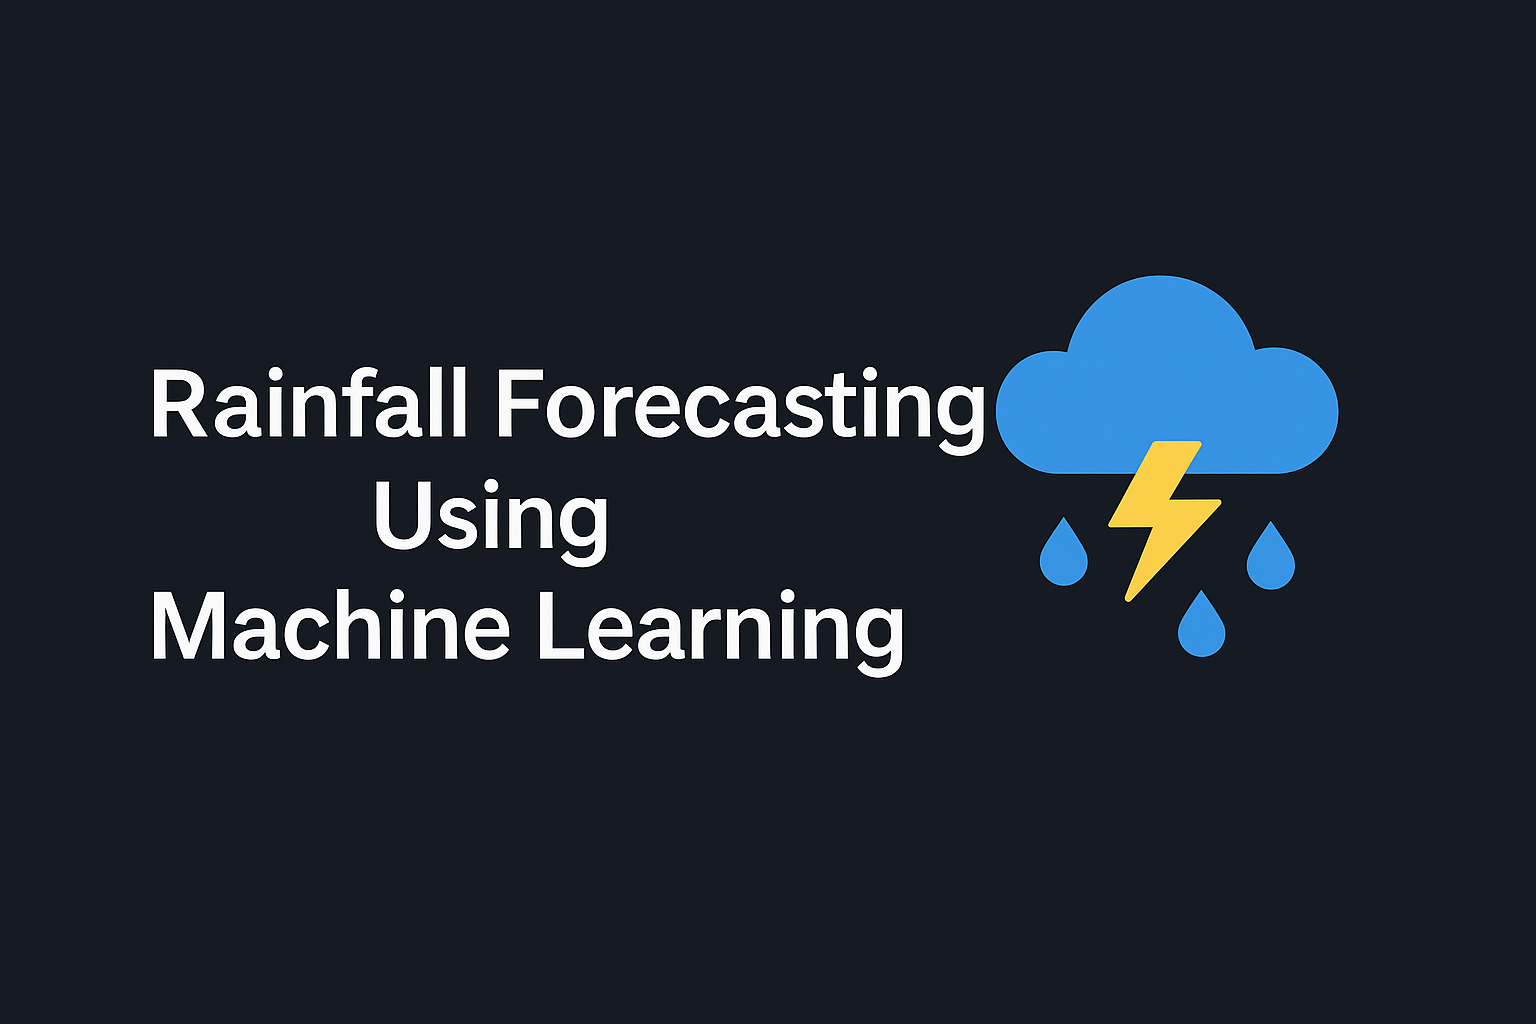

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

The objective of this challenge is to predict the type of rain to be expected in the next 12 to 24 hours.

In [2]:
# Load dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,ID,user_id,confidence,predicted_intensity,community,district,prediction_time,indicator,indicator_description,time_observed,Target,forecast_length
0,ID_KwcTp_12,11,0.3,0.0,Tumfa,atiwa_west,2025-05-30 11:09:33,NaN,NaN,NaN,MEDIUMRAIN,12
1,ID_K9vWT_12,17,0.3,0.0,Kwabeng,atiwa_west,2025-05-30 11:09:35,NaN,NaN,NaN,HEAVYRAIN,12
2,ID_AIQg3_12,19,0.3,0.0,Akropong,atiwa_west,2025-05-30 11:09:47,NaN,NaN,NaN,MEDIUMRAIN,12
3,ID_px4yf_12,23,0.3,0.0,Asamama,atiwa_west,2025-05-30 11:16:33,NaN,NaN,NaN,HEAVYRAIN,12
4,ID_QYYmK_12,23,0.3,0.0,Asamama,atiwa_west,2025-05-30 11:16:55,NaN,NaN,NaN,HEAVYRAIN,12


In [3]:
test.head()

,ID,user_id,confidence,predicted_intensity,community,district,prediction_time,indicator,indicator_description,time_observed,forecast_length
0,ID_SbTdy_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:28,NaN,NaN,NaN,24
1,ID_SBKYz_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:29,NaN,NaN,NaN,24
2,ID_fAimg_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:30,NaN,NaN,NaN,24
3,ID_2wBqC_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:31,NaN,NaN,NaN,24
4,ID_NItox_24,77,0.3,0.0,ASSIN BROFOYEDUR,assin_fosu,2025-07-20 19:27:32,NaN,NaN,NaN,24


In [4]:
print("Train DataFrame Info:")
train.info()

Train DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10928 entries, 0 to 10927
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     10928 non-null  object 
 1   user_id                10928 non-null  int64  
 2   confidence             10928 non-null  float64
 3   predicted_intensity    10928 non-null  float64
 4   community              10928 non-null  object 
 5   district               10928 non-null  object 
 6   prediction_time        10928 non-null  object 
 7   indicator              503 non-null    object 
 8   indicator_description  346 non-null    object 
 9   time_observed          72 non-null     object 
 10  Target                 10928 non-null  object 
 11  forecast_length        10928 non-null  int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 1.0+ MB


In [5]:
print("\nTest DataFrame Info:")
test.info()


Test DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2732 entries, 0 to 2731
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     2732 non-null   object 
 1   user_id                2732 non-null   int64  
 2   confidence             2732 non-null   float64
 3   predicted_intensity    2732 non-null   float64
 4   community              2732 non-null   object 
 5   district               2732 non-null   object 
 6   prediction_time        2732 non-null   object 
 7   indicator              205 non-null    object 
 8   indicator_description  205 non-null    object 
 9   time_observed          205 non-null    object 
 10  forecast_length        2732 non-null   int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 234.9+ KB


In [6]:
print("\nMissing values in Train DataFrame:")
print(train.isnull().sum())


Missing values in Train DataFrame:
ID                           0
user_id                      0
confidence                   0
predicted_intensity          0
community                    0
district                     0
prediction_time              0
indicator                10425
indicator_description    10582
time_observed            10856
Target                       0
forecast_length              0
dtype: int64


In [7]:
print("\nMissing values in Test DataFrame:")
print(test.isnull().sum())


Missing values in Test DataFrame:
ID                          0
user_id                     0
confidence                  0
predicted_intensity         0
community                   0
district                    0
prediction_time             0
indicator                2527
indicator_description    2527
time_observed            2527
forecast_length             0
dtype: int64


In [8]:
train.indicator.unique()

array([nan, 'heat', 'sun', 'clouds', 'wind', 'dew', 'fog', 'star',
       'thunder', 'moon', 'lightning'], dtype=object)

In [9]:
#the correlation between indicator and Target
print("\nCorrelation between indicator and Target:")
print(pd.crosstab(train['indicator'], train['Target']))


Correlation between indicator and Target:
Target     HEAVYRAIN  MEDIUMRAIN  NORAIN  SMALLRAIN
indicator                                          
clouds             6          26     212         22
dew                0           0       9          0
fog                0           0      27          0
heat               5          11      37          0
lightning          0           1       1          0
moon               0           0      17          2
star               0           0       7          1
sun                2           3      74         11
thunder            0           0       4          0
wind               0           0      22          3


In [10]:
#the indicator column null values have to be filled
# Step 1: Define mapping between target and indicator
indicator_map = {
    'NORAIN': ['dew', 'fog', 'thunder', 'star', 'moon', 'heat','sun', 'wind','clouds'],
    'SMALLRAIN': ['wind', 'star', 'moon', 'sun','clouds'],
    'MEDIUMRAIN': ['heat', 'lightning', 'sun','clouds'],
    'HEAVYRAIN': ['heat', 'sun','clouds']
}

# Step 2: Fill null indicators based on the target column
def fill_indicator(row):
    if pd.isna(row['indicator']):
        options = indicator_map[row['Target']]
        return np.random.choice(options)
    return row['indicator']

train['indicator'] = train.apply(fill_indicator, axis=1)
#test['indicator'] = test.apply(fill_indicator, axis=1)
# Step 3: Confirm all filled
print(train['indicator'].isna().sum())

0


In [11]:
# Get the probability distribution of indicators in train
indicator_probs = train['indicator'].value_counts(normalize=True)

In [12]:
# Fill nulls by randomly sampling according to the distribution
def random_fill_indicator():
    return np.random.choice(indicator_probs.index, p=indicator_probs.values)

test['indicator'] = test['indicator'].apply(
    lambda x: random_fill_indicator() if pd.isna(x) else x
)


In [13]:
train["prediction_time"] = pd.to_datetime(train["prediction_time"])

# Extract features
# Train
#train["date"] = train["prediction_time"].dt.date
train["year"] = train["prediction_time"].dt.year
train["dayofweek"] = train["prediction_time"].dt.dayofweek
train["month"] = train["prediction_time"].dt.month
train["day"] = train["prediction_time"].dt.day
train["hour"] = train["prediction_time"].dt.hour

# Test
test["prediction_time"] = pd.to_datetime(test["prediction_time"])
#test["date"] = test["prediction_time"].dt.date
test["year"] = test["prediction_time"].dt.year
test["dayofweek"] = test["prediction_time"].dt.dayofweek
test["month"] = test["prediction_time"].dt.month
test["day"] = test["prediction_time"].dt.day
test["hour"] = test["prediction_time"].dt.hour

In [14]:
# Strip spaces and standardize casing in community col
train['community'] = train['community'].str.replace('  ', ' ').str.strip().str.title()
test['community'] = test['community'].str.replace('  ', ' ').str.strip().str.title()

print("Cleaned unique communities in Train DataFrame:")
print(train['community'].unique())

Cleaned unique communities in Train DataFrame:
['Tumfa' 'Kwabeng' 'Akropong' 'Asamama' 'Akwaduuso' 'Banso' 'Awenare'
 'Mouso' 'Abomosu' 'Foso Odumasi' 'Amonom' 'Asunafo' 'Apampatia'
 'Assin Atonsu' 'Odumasi' 'Assin Wurakese' 'Odumasi Adansi'
 'Assin Aponsie' 'Assin Nyankomasi' 'Assin Foso Odumasi'
 'Assin Mesre Nyame' 'Assin Brofoyedur' 'Mampamhwe' 'Atonsu']


In [15]:
# Store IDs for submission
test_ids = test["ID"]

In [16]:
train = train.drop(columns=["ID", "prediction_time", "indicator_description", "time_observed"])
test = test.drop(columns=["ID", "prediction_time", "indicator_description", "time_observed"])

In [17]:
# unique communities
train_comm = set(train['community'].unique())
test_comm = set(test['community'].unique())

# unseen communities in test
unseen_comm = test_comm - train_comm
print("Unseen communities in test set:", unseen_comm)

Unseen communities in test set: {'Jimiso', 'Domeabra', 'Dompim', 'Asonkore'}


In [18]:
# replace unseen test communities with 'Other'
test['community'] = test['community'].apply(lambda x: x if x in train_comm else 'Other')

### EDA


Class distribution (%):
 Target
NORAIN        87.957540
MEDIUMRAIN     6.963763
HEAVYRAIN      2.882504
SMALLRAIN      2.196193
Name: proportion, dtype: float64


Text(0, 0.5, 'Count')

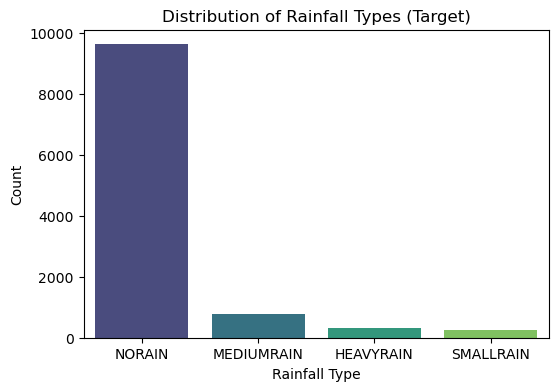

In [19]:
# Target Distribution
# Value counts
target_counts = train["Target"].value_counts()

# Percentage
print("\nClass distribution (%):\n", train["Target"].value_counts(normalize=True) * 100)

# Plot
plt.figure(figsize=(6,4))
sns.countplot(x="Target", data=train, order=target_counts.index, palette="viridis")
plt.title("Distribution of Rainfall Types (Target)")
plt.xlabel("Rainfall Type")
plt.ylabel("Count")

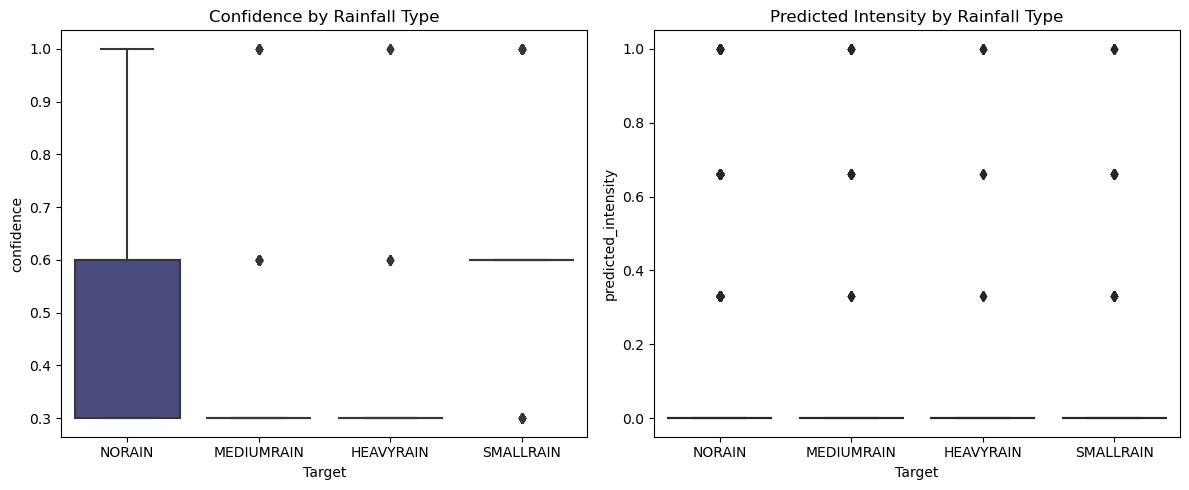

In [20]:
plt.figure(figsize=(12,5))

# Confidence vs Target
plt.subplot(1,2,1)
sns.boxplot(x="Target", y="confidence", data=train,
            palette="viridis", order=train["Target"].value_counts().index)
plt.title("Confidence by Rainfall Type")

# Predicted intensity vs Target
plt.subplot(1,2,2)
sns.boxplot(x="Target", y="predicted_intensity", data=train,
            palette="magma", order=train["Target"].value_counts().index)
plt.title("Predicted Intensity by Rainfall Type")

plt.tight_layout()


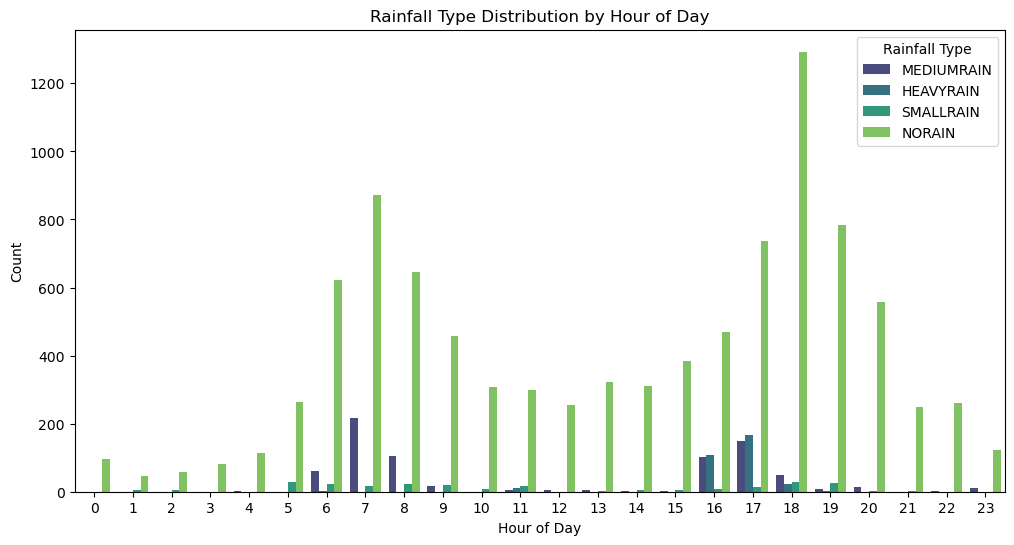

In [21]:
plt.figure(figsize=(12,6))
sns.countplot(x="hour", hue="Target", data=train, palette="viridis")
plt.title("Rainfall Type Distribution by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.legend(title="Rainfall Type")
plt.show()

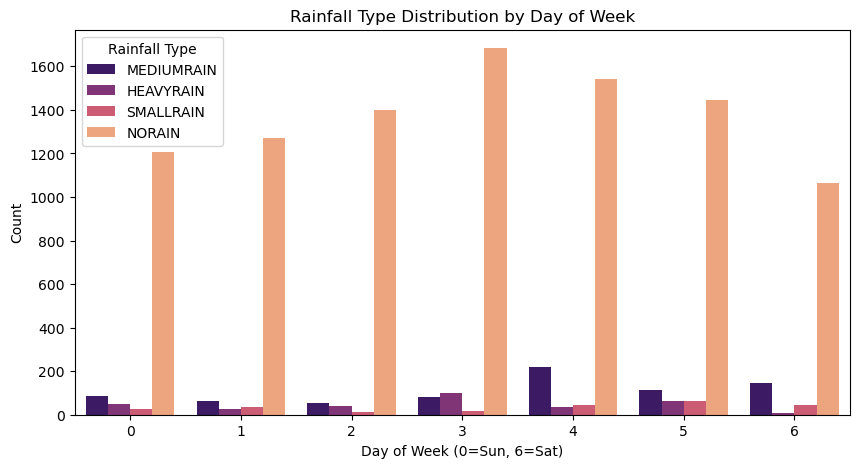

In [22]:
plt.figure(figsize=(10,5))
sns.countplot(x="dayofweek", hue="Target", data=train, palette="magma")
plt.title("Rainfall Type Distribution by Day of Week")
plt.xlabel("Day of Week (0=Sun, 6=Sat)")
plt.ylabel("Count")
plt.legend(title="Rainfall Type")
plt.show()


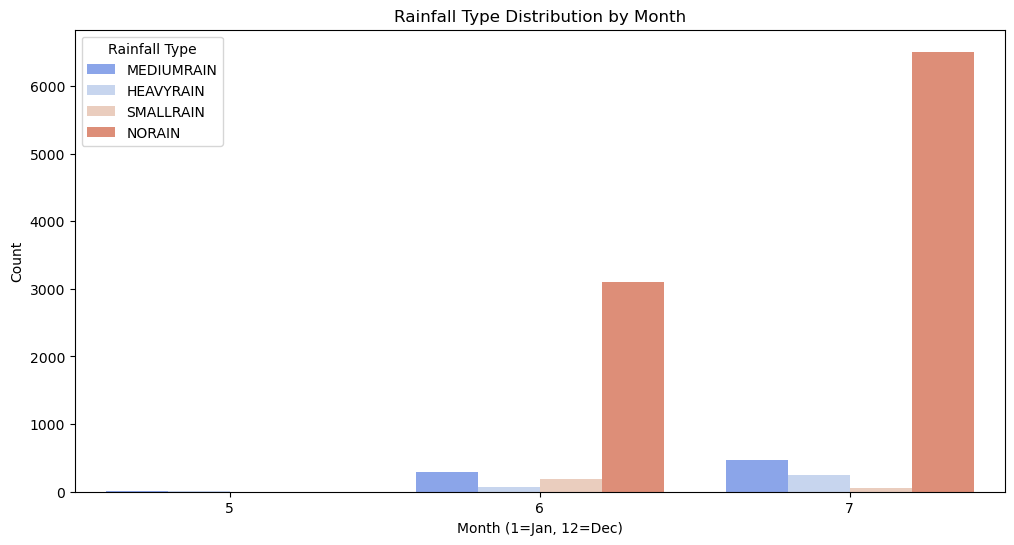

In [23]:
plt.figure(figsize=(12,6))
sns.countplot(x="month", hue="Target", data=train, palette="coolwarm")
plt.title("Rainfall Type Distribution by Month")
plt.xlabel("Month (1=Jan, 12=Dec)")
plt.ylabel("Count")
plt.legend(title="Rainfall Type")
plt.show()

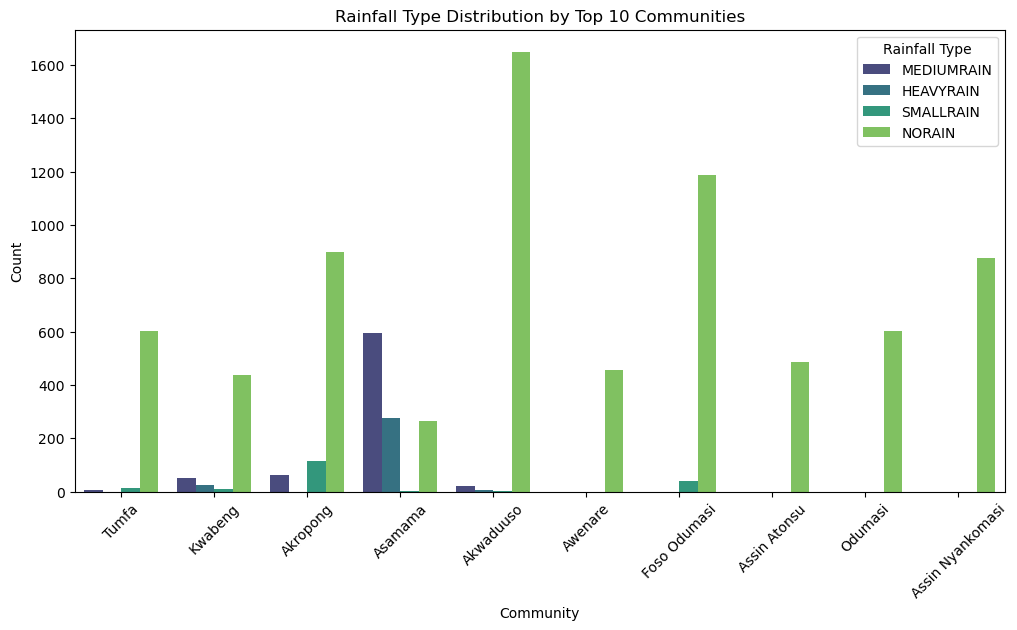

In [24]:
# Top 10 communities by record count
top_communities = train["community"].value_counts().head(10).index

plt.figure(figsize=(12,6))
sns.countplot(x="community", hue="Target", data=train[train["community"].isin(top_communities)], palette="viridis")
plt.title("Rainfall Type Distribution by Top 10 Communities")
plt.xticks(rotation=45)
plt.xlabel("Community")
plt.ylabel("Count")
plt.legend(title="Rainfall Type")
plt.show()


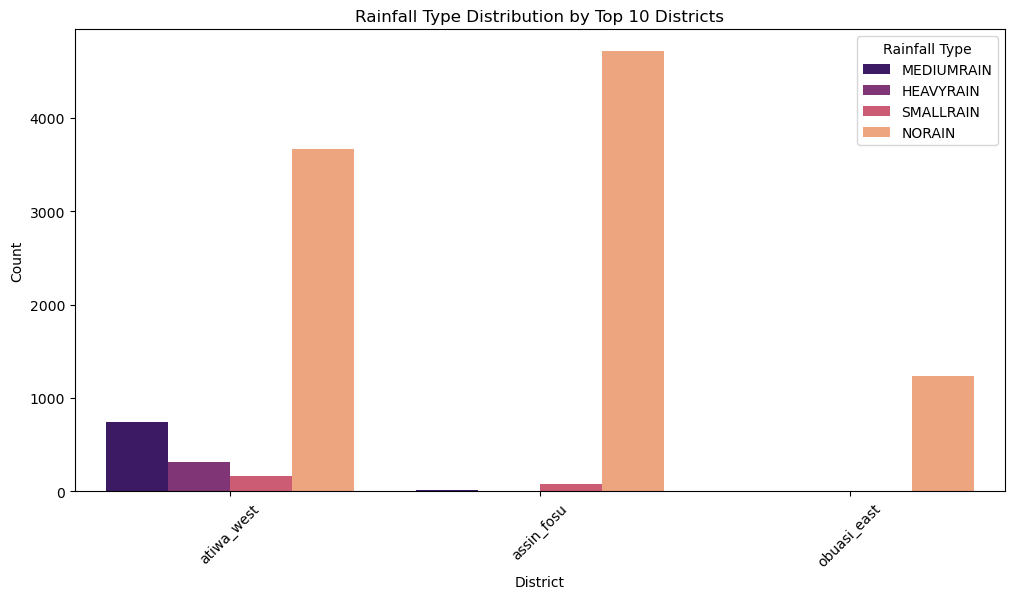

In [25]:
# Top 10 districts by record count
top_districts = train["district"].value_counts().head(10).index

plt.figure(figsize=(12,6))
sns.countplot(x="district", hue="Target", data=train[train["district"].isin(top_districts)], palette="magma")
plt.title("Rainfall Type Distribution by Top 10 Districts")
plt.xticks(rotation=45)
plt.xlabel("District")
plt.ylabel("Count")
plt.legend(title="Rainfall Type")
plt.show()

### Preprocessing

In [26]:
# ===== Features & Target =====
X = train.drop(columns=["Target"], errors="ignore")
y = train["Target"]

In [27]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(train['Target'])

In [28]:
# ===== Preprocessing Pipeline =====

numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])
categorical_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
 ("encoder", OneHotEncoder(handle_unknown="ignore"))])

In [29]:
# Identify numeric & categorical columns

num_cols = X.select_dtypes(include=["float64", "int64"]).columns

cat_cols = X.select_dtypes(include=["object"]).columns

In [30]:
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, num_cols),
                                               ("cat", categorical_transformer, cat_cols)])

In [31]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from collections import Counter
from imblearn.over_sampling import SMOTE

#imported from the classification notebook
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.preprocessing import StandardScaler

In [32]:
# ===== Train-Test Split =====

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [33]:
#!pip install xgboost lightgbm catboost

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


In [35]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_seed=42)
}


In [36]:
results = []

for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', model)])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    
    f1 = f1_score(y_val, y_pred, average='weighted')
    cm = confusion_matrix(y_val, y_pred)
    
    results.append({'Model': name, 'F1 Score': f1})
    
    print(f"=== {name} ===")
    print("F1 Score:", round(f1, 4))
    #print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(y_val, y_pred))
    print("-" * 60)

=== Logistic Regression ===
F1 Score: 0.9348
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.95      0.71        63
           1       0.91      0.60      0.72       152
           2       0.97      0.99      0.98      1923
           3       0.67      0.12      0.21        48

    accuracy                           0.94      2186
   macro avg       0.78      0.67      0.65      2186
weighted avg       0.94      0.94      0.93      2186

------------------------------------------------------------
=== Decision Tree ===
F1 Score: 0.9527
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.95      0.69        63
           1       0.88      0.64      0.75       152
           2       0.98      0.98      0.98      1923
           3       0.79      0.62      0.70        48

    accuracy                           0.95      2186
   macro avg       0.80      0.80      0.78   

  File "/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/joblib/externals/loky/backend/context.py", line 217, in _count_physical_cores
    raise ValueError(


=== LightGBM ===
F1 Score: 0.9543
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.95      0.69        63
           1       0.90      0.64      0.75       152
           2       0.98      0.99      0.98      1923
           3       0.83      0.62      0.71        48

    accuracy                           0.95      2186
   macro avg       0.82      0.80      0.79      2186
weighted avg       0.96      0.95      0.95      2186

------------------------------------------------------------
=== CatBoost ===
F1 Score: 0.9547
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.94      0.69        63
           1       0.90      0.64      0.75       152
           2       0.98      0.99      0.98      1923
           3       0.84      0.67      0.74        48

    accuracy                           0.95      2186
   macro avg       0.82      0.81      0.79      2186
weighted

In [38]:
results_df = pd.DataFrame(results).sort_values(by='F1 Score', ascending=False)
results_df

,Model,F1 Score
6,CatBoost,0.954685
4,XGBoost,0.954583
5,LightGBM,0.954342
2,Random Forest,0.954287
1,Decision Tree,0.952652
0,Logistic Regression,0.934763
3,SVM,0.823384


In [39]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
import joblib
X = train.drop('Target', axis=1)
final_model = CatBoostClassifier(verbose=0, random_state=42)

final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', final_model)
])

final_pipeline.fit(X, y)

#Predict on test 
X_test = test.copy()  

#probabilities:
y_proba = final_pipeline.predict_proba(X_test)  
y_pred_encoded = final_pipeline.predict(X_test)  
y_pred_labels = le.inverse_transform(y_pred_encoded)  

#Save predictions to CSV (with class probs)
proba_cols = [f"prob_{cls}" for cls in le.classes_]  
pred_df = pd.DataFrame(y_proba, columns=proba_cols, index=test.index)
pred_df['predicted_label'] = y_pred_labels

# Optionally include original test features (or just ids)
# pred_df = pd.concat([test[['id_column_if_any']], pred_df], axis=1)

pred_df.to_csv("test_predictions.csv", index=True)
print("Saved predictions to test_predictions.csv")

# 5) Save pipeline + label encoder for future use
joblib.dump({'pipeline': final_pipeline, 'label_encoder': le}, "final_pipeline_and_encoder.pkl")
print("Saved pipeline and label encoder to final_pipeline_and_encoder.pkl")


Saved predictions to test_predictions.csv
Saved pipeline and label encoder to final_pipeline_and_encoder.pkl


In [41]:
pred_df.head()

,prob_HEAVYRAIN,prob_MEDIUMRAIN,prob_NORAIN,prob_SMALLRAIN,predicted_label
0,0.000002,0.000009,0.999941,0.000048,NORAIN
1,0.000001,0.000008,0.999943,0.000047,NORAIN
2,0.000001,0.000006,0.999843,0.000150,NORAIN
3,0.000019,0.000108,0.999863,0.000010,NORAIN
4,0.000002,0.000009,0.999941,0.000048,NORAIN


In [43]:
# Suppose your test set has an ID column named 'id' (adjust if different)
submission = pd.DataFrame({
    'id': test_ids,                  
    'Target': y_pred_labels})

# Save to CSV
submission.to_csv('rainfall_predictions_submission.csv', index=False)

print("✅ Submission file saved as 'rainfall_predictions_submission.csv'")
print(submission.head())


✅ Submission file saved as 'rainfall_predictions_submission.csv'
            id  Target
0  ID_SbTdy_24  NORAIN
1  ID_SBKYz_24  NORAIN
2  ID_fAimg_24  NORAIN
3  ID_2wBqC_24  NORAIN
4  ID_NItox_24  NORAIN
